In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_orient = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel_orient = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobel_orient)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    assert sobel_kernel%2 == 1
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    magnitude = np.sqrt(np.power(sobel_x,2)+ np.power(sobel_y,2))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # 5) 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    assert sobel_kernel%2 == 1
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    # 4) Calculate direction of the gradient
    angle = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(gray)
    sxbinary[(angle >= thresh[0]) & (angle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

In [3]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary_output

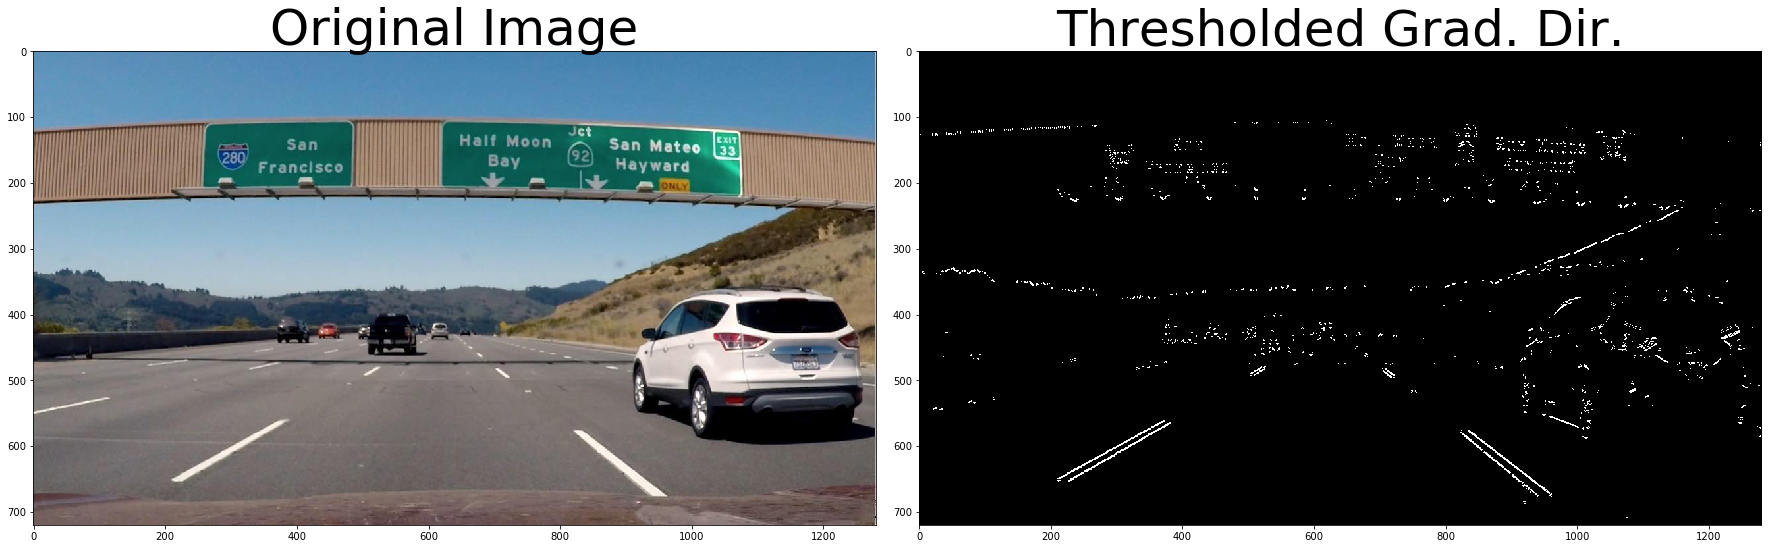

In [4]:
# Read in an image
image = mpimg.imread('assets/signs_vehicles_xygrad.png')

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(45, 120))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(65, 120))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(60, 120))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.3))
#dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [240]:
def pipeline(img):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    
    thr = (30,100)
    kernel_size = 15
    channel = cv2.GaussianBlur(s_channel, (kernel_size, kernel_size), 0)
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary_s = np.zeros_like(scaled_sobel)
    sxbinary_s[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1
    
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV).astype(np.float)
    u_channel = yuv[:,:,2]
    
    channel = cv2.GaussianBlur(u_channel, (kernel_size, kernel_size), 0)
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary_u = np.zeros_like(scaled_sobel)
    sxbinary_u[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1  

    R = img[:,:,0]
    thresh = (200, 255)
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1

    combined = np.zeros_like(binary)
    combined[(binary == 1) | ((sxbinary_s == 1) & (sxbinary_u == 1))] = 1   # (h_binary == 1) | 
    

    return combined

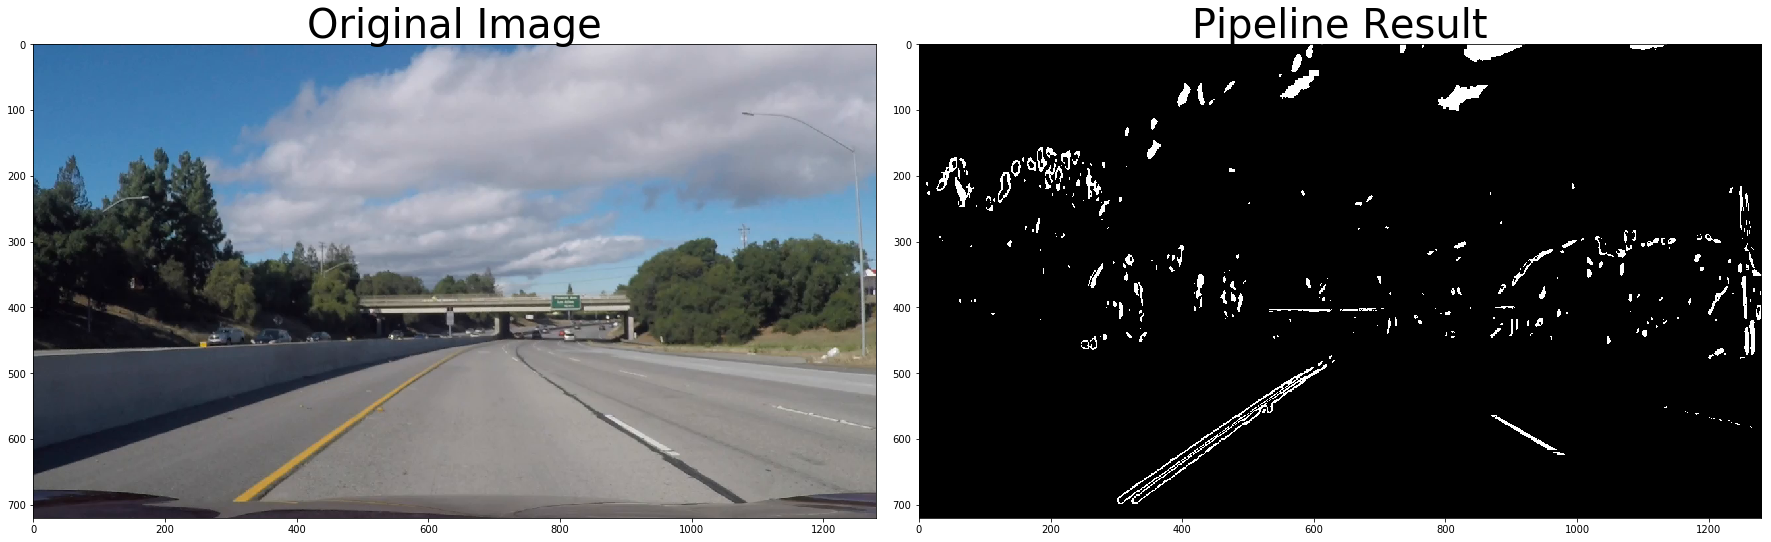

In [241]:
from moviepy.editor import *
video_file = "test_videos/challenge_video.mp4"
video = VideoFileClip(video_file)

#for frame in video.iter_frames():
    #print(frame.shape)

time = 0
image = video.get_frame(time)

result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


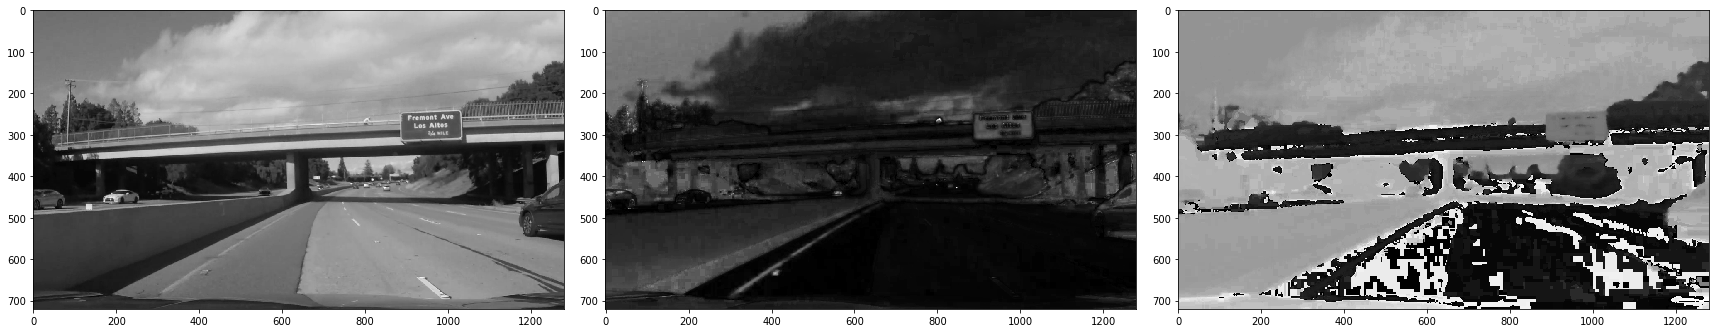

In [221]:
original = np.copy(image)
# Convert to HSV color space and separate the V channel
hsv = cv2.cvtColor(original, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hsv[:,:,1]
s_channel = hsv[:,:,2]
h_channel = hsv[:,:,0]
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(l_channel, cmap='gray')
ax2.imshow(s_channel, cmap='gray')
ax3.imshow(h_channel, cmap='gray')

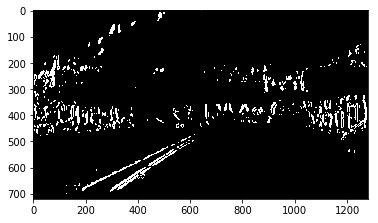

In [224]:
thr = (30,100)
kernel_size = 15
channel = cv2.GaussianBlur(s_channel, (kernel_size, kernel_size), 0)
sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1

plt.imshow(sxbinary, cmap='gray')

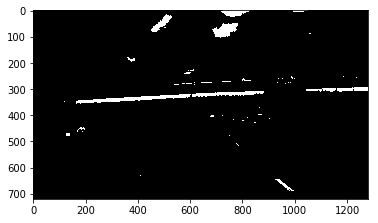

In [229]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

plt.imshow(binary, cmap='gray')

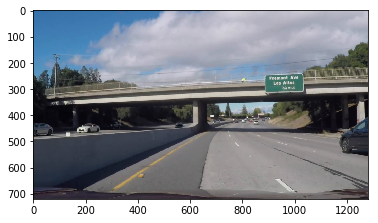

In [215]:
plt.imshow(image)

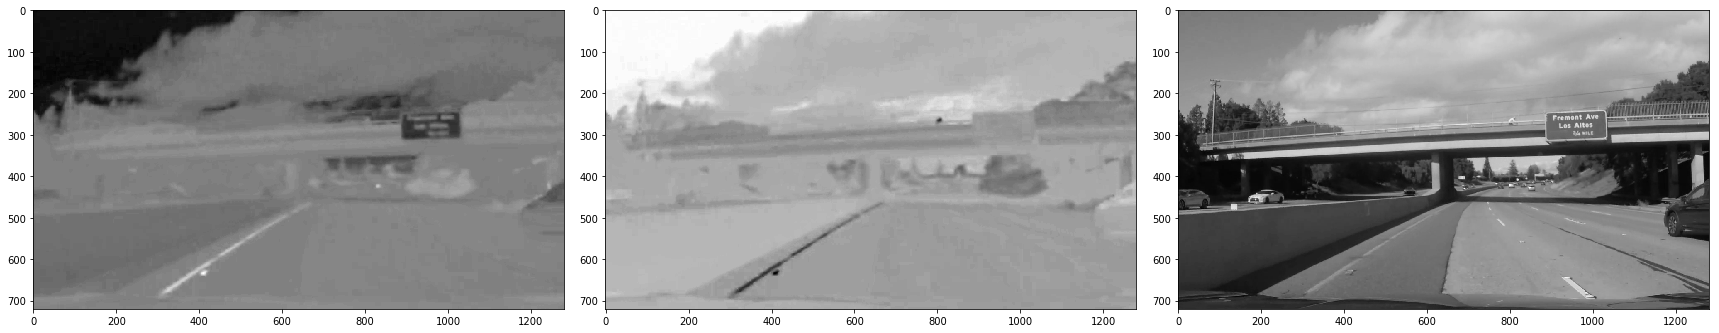

In [230]:
original = np.copy(image)
# Convert to HSV color space and separate the V channel
hsv = cv2.cvtColor(original, cv2.COLOR_RGB2YUV).astype(np.float)
l_channel = hsv[:,:,1]
s_channel = hsv[:,:,2]
h_channel = hsv[:,:,0]
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(l_channel, cmap='gray')
ax2.imshow(s_channel, cmap='gray')
ax3.imshow(h_channel, cmap='gray')

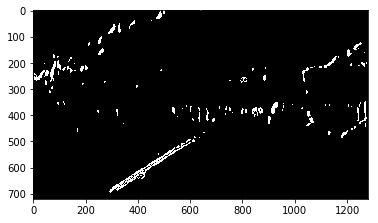

In [231]:
thr = (30,100)
kernel_size = 15
channel = cv2.GaussianBlur(s_channel, (kernel_size, kernel_size), 0)
sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1

plt.imshow(sxbinary, cmap='gray')